## Transfer learning  Based on ResNet34 for Methylation Data

The network in this notebook is an implementation of the ResNet-50 [1] architecture on the CelebA face dataset [2] to train a gender classifier.  


References
    
- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] Zhang, K., Tan, L., Li, Z., & Qiao, Y. (2016). Gender and smile classification using deep convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (pp. 34-38).

The ResNet-50 architecture is similar to the ResNet-34 architecture shown below (from [1]):


![](resnets/resnet34/resnet34-arch.png)

However, in ResNet-50, the skip connection uses a bottleneck (from [1]):


![](resnets/resnet50/resnet50-arch-1.png)



The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.

![](resnets/resnet-ex-1-1.png)


The ResNet-34 architecture actually uses residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:

![](resnets/resnet-ex-1-2.png)

The ResNet-50 uses a bottleneck as shown below:

![](resnets/resnet-ex-1-3.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [96]:
import os
from pathlib import PosixPath
import time

In [3]:
import pandas as pd
import numpy as np

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary

## Settings

In [124]:
## Hyper-paremeters
BATCH_SIZE = 5
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
RANDOM_SEED = 42


## Model Architecture
NUM_CLASSES = 2

DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

## Dataset explore

[Dataset Link](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE66695)

Summary	Genome wide DNA methylation profiling of normal and breast cancer samples. The Illumina Infinium 450k Human DNA methylation Beadchip v1.1 was used to obtain DNA methylation profiles across approximately 485577 CpGs in breast cancer and normal samples. Samples included 40 normal, 80 breast cancer samples.
 	
Overall design	Bisulphite converted DNA from the 120 samples were hybridised to the Illumina Infinium 450k Human Methylation Beadchip v1.1

In [125]:
root_dir = PosixPath(".")
dataset_path = "GSE66695_series_matrix.txt"

In [126]:
data_matrix  = pd.read_table(root_dir/dataset_path)

In [127]:
data_matrix.head()

,ID_REF,GSM1629194,GSM1629195,GSM1629196,GSM1629197,GSM1629198,GSM1629199,GSM1629200,GSM1629201,GSM1629202,...,GSM1629304,GSM1629305,GSM1629306,GSM1629307,GSM1629308,GSM1629309,GSM1629310,GSM1629311,GSM1629312,GSM1629313
0,cg00000029,0.334061,0.178954,0.172730,0.183075,0.072717,0.195457,0.287615,0.339056,0.195401,...,0.171595,0.220228,0.224031,0.096429,0.226318,0.169211,0.215496,0.181659,0.424289,0.168877
1,cg00000108,0.935733,0.937377,0.929570,0.924546,0.922173,0.880320,0.909696,0.929620,0.903362,...,0.915011,0.909828,0.918342,0.944021,0.935265,0.929773,0.901808,0.907297,0.917796,0.932770
2,cg00000109,0.874611,0.738671,0.741349,0.856688,0.871578,0.686862,0.730466,0.850274,0.712961,...,0.838718,0.772767,0.737013,0.892180,0.854146,0.688073,0.756057,0.732730,0.828793,0.879740
3,cg00000165,0.593666,0.251576,0.258572,0.332309,0.277692,0.161782,0.205542,0.543108,0.227433,...,0.202314,0.249808,0.230911,0.136585,0.380056,0.237408,0.229581,0.246965,0.178193,0.655175
4,cg00000236,0.864638,0.820130,0.800612,0.884483,0.862696,0.802741,0.793261,0.838466,0.798712,...,0.891121,0.793986,0.839779,0.868582,0.857674,0.830082,0.802358,0.801136,0.888044,0.861329


In [128]:
data_matrix.shape

(485578, 121)

In [129]:
data_matrix.drop("ID_REF", inplace=True, axis = 1)

In [130]:
sample_names = "GSM1629194 GSM1629195 GSM1629196 GSM1629197 GSM1629198 GSM1629199 GSM1629200 GSM1629201 GSM1629202 GSM1629203 GSM1629204 GSM1629205 GSM1629206 GSM1629207 GSM1629208 GSM1629209 GSM1629210 GSM1629211 GSM1629212 GSM1629213 GSM1629214 GSM1629215 GSM1629216 GSM1629217 GSM1629218 GSM1629219 GSM1629220 GSM1629221 GSM1629222 GSM1629223 GSM1629224 GSM1629225 GSM1629226 GSM1629227 GSM1629228 GSM1629229 GSM1629230 GSM1629231 GSM1629232 GSM1629233 GSM1629234 GSM1629235 GSM1629236 GSM1629237 GSM1629238 GSM1629239 GSM1629240 GSM1629241 GSM1629242 GSM1629243 GSM1629244 GSM1629245 GSM1629246 GSM1629247 GSM1629248 GSM1629249 GSM1629250 GSM1629251 GSM1629252 GSM1629253 GSM1629254 GSM1629255 GSM1629256 GSM1629257 GSM1629258 GSM1629259 GSM1629260 GSM1629261 GSM1629262 GSM1629263 GSM1629264 GSM1629265 GSM1629266 GSM1629267 GSM1629268 GSM1629269 GSM1629270 GSM1629271 GSM1629272 GSM1629273 GSM1629274 GSM1629275 GSM1629276 GSM1629277 GSM1629278 GSM1629279 GSM1629280 GSM1629281 GSM1629282 GSM1629283 GSM1629284 GSM1629285 GSM1629286 GSM1629287 GSM1629288 GSM1629289 GSM1629290 GSM1629291 GSM1629292 GSM1629293 GSM1629294 GSM1629295 GSM1629296 GSM1629297 GSM1629298 GSM1629299 GSM1629300 GSM1629301 GSM1629302 GSM1629303 GSM1629304 GSM1629305 GSM1629306 GSM1629307 GSM1629308 GSM1629309 GSM1629310 GSM1629311 GSM1629312 GSM1629313"
sample_title = "01-208-T  01-254-N  01-212-N  01-254-T  01-212-T  01-265-N  01-237-N  01-265-T  01-242-N  01-302-N  01-242-T  01-302-T  00-105-T  00-395-T  00-135-T  00-409-T  00-151-T  00-401-T  00-172-T  00-480-T  00-185-T  00-522-T  00-225-T  00-529-T  00-530-T  00-462-N  00-525-N  00-525-T  99-029-T  99-301-T  99-066-T  00-200-T  99-165-T  00-292-T  99-188-T  00-301-T  99-225-T  01-201-T  99-260-T  01-218-T  01-219-T  01-367-T  01-262-T  99-066-N  01-273-T  01-255-N  01-276-T  01-367-N  01-280-T  01-298-N  01-340-T  01-298-T  00-218-T  BS66770-N 00-291-N  BS66755-N 00-291-T  BS66498-N 01-060-T  BS66689-N 00-012-N  BS66172-N 00-012-T  BS66352-N 67777-N   67763-T   BS66770-T 67777-T   BS66352-T BS66755-T BS66689-T BS66459-T 00-144-N  00-391-T  00-164-N  01-015-N  00-218-N  01-015-T  01-123-T  01-045-T  00-359-T  01-061-N  00-360-T  01-061-T  01-066-T  01-168-T  01-116-T  01-169-T  01-144-N  01-177-N  01-144-T  01-177-T  01-148-T  01-186-N  01-168-N  01-186-T  01-199-N  99-273-N  01-199-T  99-312-T  99-013-T  99-312-T-2    99-073-T  99-344-T  99-217-N  99-359-N  99-217-T  99-369-N  99-387-T  99-506-T  99-388-T  99-523-N  99-403-N  99-523-T  99-403-T  99-536-N  99-468-N  01-083-N  99-468-T  01-083-T"

In [131]:
target_dict = {sample: label for sample, label in zip(sample_names.split(), sample_title.split())}

In [132]:
target_dict

{'GSM1629194': '01-208-T',
 'GSM1629195': '01-254-N',
 'GSM1629196': '01-212-N',
 'GSM1629197': '01-254-T',
 'GSM1629198': '01-212-T',
 'GSM1629199': '01-265-N',
 'GSM1629200': '01-237-N',
 'GSM1629201': '01-265-T',
 'GSM1629202': '01-242-N',
 'GSM1629203': '01-302-N',
 'GSM1629204': '01-242-T',
 'GSM1629205': '01-302-T',
 'GSM1629206': '00-105-T',
 'GSM1629207': '00-395-T',
 'GSM1629208': '00-135-T',
 'GSM1629209': '00-409-T',
 'GSM1629210': '00-151-T',
 'GSM1629211': '00-401-T',
 'GSM1629212': '00-172-T',
 'GSM1629213': '00-480-T',
 'GSM1629214': '00-185-T',
 'GSM1629215': '00-522-T',
 'GSM1629216': '00-225-T',
 'GSM1629217': '00-529-T',
 'GSM1629218': '00-530-T',
 'GSM1629219': '00-462-N',
 'GSM1629220': '00-525-N',
 'GSM1629221': '00-525-T',
 'GSM1629222': '99-029-T',
 'GSM1629223': '99-301-T',
 'GSM1629224': '99-066-T',
 'GSM1629225': '00-200-T',
 'GSM1629226': '99-165-T',
 'GSM1629227': '00-292-T',
 'GSM1629228': '99-188-T',
 'GSM1629229': '00-301-T',
 'GSM1629230': '99-225-T',
 

In [133]:
data_matrix.dropna(axis = 0,inplace=True)

In [134]:
data_matrix.shape

(408288, 120)

In [135]:
torch.from_numpy(data_matrix.iloc[:,1].values).size()

torch.Size([408288])

In [136]:
def transform_target(target):
    if target.split("-")[-1] == "N":
        return 0
    else:
        return 1   

In [137]:
target_dict = {target : transform_target(target_dict[target]) for target in target_dict}

In [138]:
data_matrix.iloc[:,0].values

array([0.9357331 , 0.8746111 , 0.593666  , ..., 0.9518182 , 0.9392812 ,
       0.04467725])

In [139]:
class GSEDataset(Dataset):
    def __init__(self, data_matrix, target_dict):
        self.data_matrix = data_matrix
        self.target_dict = target_dict
    
    def __len__(self):
        return len(self.target_dict)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data_matrix.iloc[:,idx].values).float()
        y = torch.tensor(self.target_dict[self.data_matrix.columns[idx]])
        return x,y

In [140]:
ges_dataset =  GSEDataset(data_matrix, target_dict)

In [141]:
train_size = int(0.8 * len(ges_dataset))
test_size = len(ges_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(ges_dataset, [train_size, test_size])

In [142]:
train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

dataset_loader = {"train": train_dataloader, "test": test_dataloader}

## Transfer Model

In [143]:
resnet = torchvision.models.resnet34(pretrained=True)

In [144]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [145]:
for name, m in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [146]:
x,y = next(iter(dataset_loader["train"]))

In [147]:
x.size(), y.size()

(torch.Size([5, 408288]), torch.Size([5]))

In [148]:
def div_prime(num):
    res = []
    while num != 1:
        for i in range(2, int(num+1)):
            if num % i == 0:
                res.append(i)
                num = num // i
                break
 
    return res
div_prime(408288)

[2, 2, 2, 2, 2, 3, 4253]

# Model

In [149]:
class GESMODEL(torch.nn.Module):
    def __init__(self, num_class = NUM_CLASSES):
        super(GESMODEL, self).__init__()
        
        self.adaptive_pool = torch.nn.AdaptiveAvgPool2d((224,224))
        self.resenet = torchvision.models.resnet34(pretrained=True)
        
#         for param in self.resenet.parameters():
#             param.requires_grad = False
        
        
        self.resenet.fc = nn.Linear(self.resenet.fc.in_features,NUM_CLASSES)
        torch.nn.init.normal_(self.resenet.fc.weight, 0, 0.01)
        torch.nn.init.constant_(self.resenet.fc.bias, 0)
        
    def forward(self, x):
        x = x.view(-1, 3,32,4253)
        x = self.adaptive_pool(x)
        logits = self.resenet(x)
        probas = F.softmax(logits, dim = 1)
        return logits,probas

In [150]:
model = GESMODEL().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [151]:
summary(model, (408288,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
              ReLU-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
       BasicBlock-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

## Training

In [152]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [153]:
def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    train_acc_list, valid_acc_list = [], []
    
    for epoch in range(num_epochs):
        start = time.time()
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())

            print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.2f}'.format(
                epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, loss))
        
        end = time.time()
        with torch.set_grad_enabled(False):
            train_acc = metric_func(model, data_loader["train"], device)
            valid_acc = metric_func(model, data_loader["test"], device)
            
            print('Epoch: {0:03d}/{1:03d} train acc: {2:.3f} % | val acc: {3:.3f} % | time: {4:.3f} s'.format(
                  epoch+1, num_epochs, train_acc, valid_acc, end-start))
            

            
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            
    return model, loss_list, train_acc_list, valid_acc_list

In [154]:
model, loss_list, train_acc_list, valid_acc_list = train_model(model, 
            dataset_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_accuracy)

Epoch: 001/010 | Batch 000/019 | Loss: 0.71
Epoch: 001/010 | Batch 001/019 | Loss: 0.67
Epoch: 001/010 | Batch 002/019 | Loss: 0.55
Epoch: 001/010 | Batch 003/019 | Loss: 0.34
Epoch: 001/010 | Batch 004/019 | Loss: 0.64
Epoch: 001/010 | Batch 005/019 | Loss: 0.28
Epoch: 001/010 | Batch 006/019 | Loss: 0.26
Epoch: 001/010 | Batch 007/019 | Loss: 0.68
Epoch: 001/010 | Batch 008/019 | Loss: 0.50
Epoch: 001/010 | Batch 009/019 | Loss: 0.21
Epoch: 001/010 | Batch 010/019 | Loss: 0.11
Epoch: 001/010 | Batch 011/019 | Loss: 0.16
Epoch: 001/010 | Batch 012/019 | Loss: 0.42
Epoch: 001/010 | Batch 013/019 | Loss: 0.56
Epoch: 001/010 | Batch 014/019 | Loss: 0.44
Epoch: 001/010 | Batch 015/019 | Loss: 0.10
Epoch: 001/010 | Batch 016/019 | Loss: 0.16
Epoch: 001/010 | Batch 017/019 | Loss: 0.21
Epoch: 001/010 | Batch 018/019 | Loss: 0.07
Epoch: 001/010 | Batch 019/019 | Loss: 0.30
Epoch: 001/010 train acc: 65.625 % | val acc: 70.833 % | time: 2.762 s
Epoch: 002/010 | Batch 000/019 | Loss: 0.37
Epoch

Epoch: 009/010 | Batch 014/019 | Loss: 0.06
Epoch: 009/010 | Batch 015/019 | Loss: 0.00
Epoch: 009/010 | Batch 016/019 | Loss: 0.02
Epoch: 009/010 | Batch 017/019 | Loss: 0.28
Epoch: 009/010 | Batch 018/019 | Loss: 0.17
Epoch: 009/010 | Batch 019/019 | Loss: 0.08
Epoch: 009/010 train acc: 100.000 % | val acc: 95.833 % | time: 2.662 s
Epoch: 010/010 | Batch 000/019 | Loss: 0.04
Epoch: 010/010 | Batch 001/019 | Loss: 0.11
Epoch: 010/010 | Batch 002/019 | Loss: 0.03
Epoch: 010/010 | Batch 003/019 | Loss: 0.01
Epoch: 010/010 | Batch 004/019 | Loss: 0.01
Epoch: 010/010 | Batch 005/019 | Loss: 0.01
Epoch: 010/010 | Batch 006/019 | Loss: 0.01
Epoch: 010/010 | Batch 007/019 | Loss: 0.02
Epoch: 010/010 | Batch 008/019 | Loss: 0.01
Epoch: 010/010 | Batch 009/019 | Loss: 0.01
Epoch: 010/010 | Batch 010/019 | Loss: 0.02
Epoch: 010/010 | Batch 011/019 | Loss: 0.08
Epoch: 010/010 | Batch 012/019 | Loss: 0.11
Epoch: 010/010 | Batch 013/019 | Loss: 0.01
Epoch: 010/010 | Batch 014/019 | Loss: 0.01
Epoc

## Result

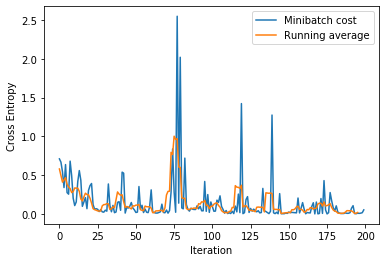

In [155]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(5,)/5, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

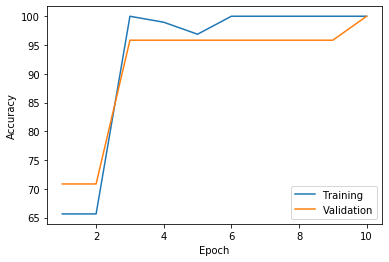

In [156]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [157]:
with torch.set_grad_enabled(False):
    test_acc = compute_accuracy(model=model,
                           data_loader=dataset_loader["test"],
                           device=DEVICE)

print(f'Test ACC: {test_acc:.2f}%')

Test ACC: 100.00%
